# Word Embeddings

In [16]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN, MeanShift
from sklearn.metrics import silhouette_score

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import plot_confusion_matrix

from functions.we_func import remove_unwanted, preprocess_for_we

In [ ]:
# Set articles to be removed based on headlines and section of news, create stopwords from NLTK, set glove_path
UNWANTED_HL = [
    'UPDATE',
    'US STOCKS',
    'PRESS']

UNWANTED_URL = [
    '/education/',
    '/politics/',
    '/diplomacy/',
    '/letters/',
    'health-',
    '/money/',
    '/transport/',
    'investing',
    '/society/']

stop_words = stopwords.words('english')
glove_path = 'glove.6B.50d.txt'

In [ ]:
f = open('articles.p', 'rb')
df = pickle.load(f)
f.close()

In [ ]:
# Preprocess the articles with functions imported from 'clean_for_we.py'
df = df.loc[(df['source'] != 'SCMP') & (df['date'] >= pd.Timestamp(2019, 3, 15))]
df = remove_unwanted(df, 'headline', UNWANTED_HL)
df = remove_unwanted(df, 'url', UNWANTED_URL)
df.reset_index(inplace=True)
df.drop(columns='index', inplace=True)
df = preprocess_for_we(df, stop_words)

In [ ]:
word_tokens = df['word_tokens']
vocab = []

for doc in word_tokens:
    for word in doc:
        vocab.append(word)
        
vocab = set(vocab)

In [ ]:
# Create dictionary of word:vector pairs from GloVe
glove = {}
with open(glove_path, 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in vocab:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [ ]:
# f = open('glove.p', 'wb')
# pickle.dump(glove, f)
# f.close()

In [ ]:
# Function to map words to vectors
def w2v(words, dictionary):
    vec = np.mean([ dictionary[word] for word in words if word in dictionary ], axis=0)
    return vec

## Word Embedding per Document Mean Classification
- XGBoost nearly across the board better than RandomForest at classifiying news article by source
- Both were better classifying articles based on mean word vector than on topic distribution and sentiment
- Slight improvements with GridSearchCV

In [ ]:
word_vecs = list(df['word_tokens'].map(lambda x: w2v(x, glove)))

In [ ]:
data = pd.DataFrame(data=word_vecs, columns=[ f'{i}' for i in range(50) ])
data['source'] = df['source']

In [ ]:
# f = open('vec_data.p', 'wb')
# pickle.dump(data, f)
# f.close()

In [2]:
f = open('vec_data.p', 'rb')
data = pickle.load(f)
f.close()

In [3]:
data['source'].value_counts()

Reuters            434
CCTV               182
ABC (Australia)    102
CNN                 81
Name: source, dtype: int64

In [4]:
X = data.drop(columns='source')
y = data['source']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train, y_train)

In [6]:
# Scoring function
def get_scores(model, test_data, test_labels):
    if len(test_data) != len(test_labels):
        return 'Data shapes incorrect'

    preds = model.predict(test_data)
    _f1 = round(f1_score(test_labels, preds, average='macro'), 4)
    _acc = round(accuracy_score(test_labels, preds), 4)
    _pre = round(precision_score(test_labels, preds, average='macro'), 4)
    _rec = round(recall_score(test_labels, preds, average='macro'), 4)
    print('F1 Score:', _f1)
    print('Accuracy:', _acc)
    print('Precision:', _pre)
    print('Recall:', _rec)
    print('--------------')
    print(confusion_matrix(test_labels, preds))

In [ ]:
get_scores(clf, X_test, y_test)

In [ ]:
preds = clf.predict(X_test)
print(classification_report(y_test, preds))

In [ ]:
xgb_clf = XGBClassifier(n_estimators=25)
xgb_clf.fit(X_train, y_train)

In [ ]:
preds = xgb_clf.predict(X_test)
print(classification_report(y_test, preds))

In [ ]:
get_scores(xgb_clf, X_test, y_test)

In [ ]:
rf = RandomForestClassifier()
scorer = make_scorer(f1_score, average = 'weighted')

params = {
    'n_estimators': [20, 25, 30, 35],
    'criterion': ['gini', 'entropy'],
#     'max_depth': [5, 6, 7, 8, 9],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'random_state': [0]
}

gs_rf = GridSearchCV(
    estimator=rf,
    param_grid=params,
    scoring=scorer,
    n_jobs=-1,
    verbose=1,
    cv=5,
)

In [ ]:
gs_rf.fit(X_train, y_train)
rf_model = gs_rf.best_estimator_
print(30*'-')
print('Best params:')
print(gs_rf.best_params_)

In [ ]:
preds = rf_model.predict(X_test)
print(classification_report(y_test, preds))

In [ ]:
get_scores(rf_model, X_test, y_test)

In [ ]:
xgb_clf = XGBClassifier()
scorer = make_scorer(f1_score, average = 'weighted')

params = {
    'n_estimators': [45, 50, 55],
    'max_depth': [6, 7, 8],
    'min_child_weight': [2, 3, 4],
    'random_state': [0],
}

gs_xgb = GridSearchCV(
    estimator=xgb_clf,
    param_grid=params,
    scoring=scorer,
    n_jobs=-1,
    verbose=1,
    cv=5,
)

In [ ]:
gs_xgb.fit(X_train, y_train)
xgb_model = gs_xgb.best_estimator_
print(30*'-')
print('Best params:')
print(gs_xgb.best_params_)

In [10]:
preds = xgb_model.predict(X_test)
print(classification_report(y_test, preds))

                 precision    recall  f1-score   support

ABC (Australia)       0.67      0.22      0.33        27
           CCTV       0.76      0.81      0.79        27
            CNN       0.44      0.27      0.33        15
        Reuters       0.73      0.91      0.81        91

       accuracy                           0.72       160
      macro avg       0.65      0.55      0.57       160
   weighted avg       0.70      0.72      0.68       160



In [11]:
get_scores(xgb_model, X_test, y_test)

F1 Score: 0.5665
Accuracy: 0.7188
Precision: 0.6511
Recall: 0.5539
--------------
[[ 6  4  0 17]
 [ 1 22  1  3]
 [ 0  1  4 10]
 [ 2  2  4 83]]


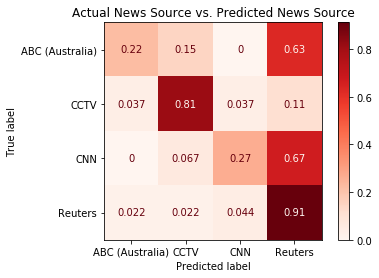

In [21]:
plot_confusion_matrix(xgb_model, X_test, y_test, normalize='true', cmap='Reds')
plt.title('Actual News Source vs. Predicted News Source')
plt.show()

In [ ]:
# f = open('xgb_model.p', 'wb')
# pickle.dump(xgb_model, f)
# f.close()

In [8]:
f = open('xgb_model.p', 'rb')
xgb_model = pickle.load(f)
f.close()

In [9]:
xgb_model.predict_proba(pd.DataFrame(X_test.iloc[0]).T)

array([[0.00277619, 0.00106102, 0.00367844, 0.9924844 ]], dtype=float32)

## Word Embedding Per Sentence Mean

In [ ]:
sentence_vecs = df['sentence_tokens'].map(lambda x: [ w2v(sents, glove) for sents in x if len(sents) != 0 ])

In [ ]:
all_sentences = []
for sents in sentence_vecs:
    for sent in sents:
        all_sentences.append(sent)

In [ ]:
data = pd.DataFrame(data=all_sentences, columns=[ f'{i}' for i in range(50) ])

In [ ]:
f = open('sent_vecs.p', 'wb')
pickle.dump(data, f)
f.close()